In [1]:
import numpy as np

from casq import PulseBackendProperties, PulseOptimizer, PulseSimulator
from casq.circuit import PulseCircuit
from casq.common import initialize_jax

initialize_jax()


In [2]:
backend_props = PulseBackendProperties("ibmq_manila")
simulator = PulseSimulator.from_backend(
    backend="ibmq_manila", qubits=[0], steps=100,
    method=PulseSimulator.ODESolverMethod.SCIPY_DOP853
)
simulator_jax=PulseSimulator.from_backend(
    backend="ibmq_manila", qubits=[0],
    method=PulseSimulator.ODESolverMethod.QISKIT_DYNAMICS_JAX_ODEINT,
    solver_options={"atol": 1e-6, "rtol": 1e-8, "hmax": backend_props.dt}
)
optimizer = PulseOptimizer(
    pulse_type=PulseOptimizer.PulseType.GAUSSIAN_SQUARE,
    pulse_arguments={
        "duration": 230, "amplitude": 1, "name": "x",
        "sigma": None, "width": None
    },
    simulator=simulator,
    target_measurement={"0": 0, "1": 1024},
    fidelity_type=PulseOptimizer.FidelityType.COUNTS,
    target_qubit=0, use_jax=False, use_jit=False
)
optimizer_jax = PulseOptimizer(
    pulse_type=PulseOptimizer.PulseType.GAUSSIAN_SQUARE,
    pulse_arguments={
        "duration": 230, "amplitude": 1, "name": "x",
        "sigma": None, "width": None
    },
    simulator=simulator_jax,
    target_measurement={"0": 0, "1": 1024},
    fidelity_type=PulseOptimizer.FidelityType.COUNTS,
    target_qubit=0, use_jax=True, use_jit=False
)


2023-07-03 09:06:44.276 | DEBUG    | casq.pulse_optimizer:_build_pulse_function:246 - Building pulse with parameters = ['sigma', 'width'] and fixed arguments = {'duration': 230, 'amplitude': 1, 'name': 'x', 'jax': False}
2023-07-03 09:06:44.277 | DEBUG    | casq.pulse_optimizer:_build_pulse_function:246 - Building pulse with parameters = ['sigma', 'width'] and fixed arguments = {'duration': 230, 'amplitude': 1, 'name': 'x', 'jax': True}


In [3]:
initial_params = np.array([10.0, 10.0])
pulse_gate = optimizer_jax.pulse_function(initial_params)
circuit = PulseCircuit.from_pulse(pulse_gate, backend_props.backend, 0)


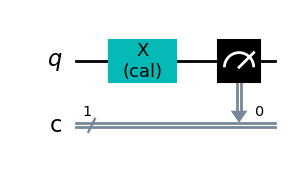

In [4]:
circuit.draw("mpl")

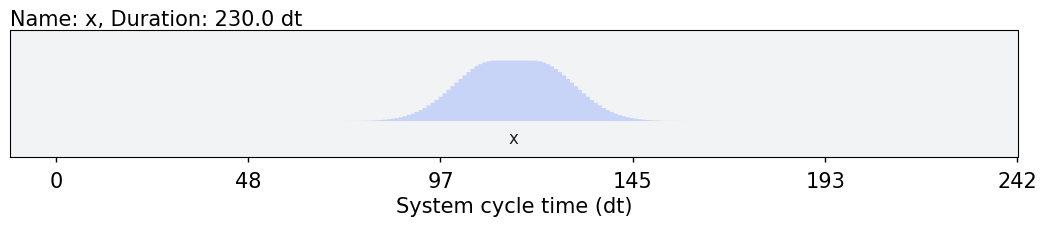

In [5]:
pulse_gate.pulse().draw()

In [6]:
%%time
optimizer.objective_function(initial_params)


2023-07-03 09:07:12.355 | DEBUG    | casq.pulse_optimizer:objective:222 - PARAMETERS: [10. 10.] TARGET: {'0': 838, '1': 186} OBJECTIVE: 0.818359375


CPU times: user 26.7 s, sys: 327 ms, total: 27.1 s
Wall time: 27.4 s


0.818359375

In [7]:
%%time
optimizer_jax.objective_function(initial_params)


2023-07-03 09:07:13.380 | DEBUG    | casq.pulse_optimizer:objective:222 - PARAMETERS: [10. 10.] TARGET: {'0': 857, '1': 167} OBJECTIVE: 0.8369140624999999


CPU times: user 983 ms, sys: 46.4 ms, total: 1.03 s
Wall time: 1.02 s


0.8369140624999999

In [8]:
%%time
solution = optimizer_jax.optimize(
    initial_params, method=PulseOptimizer.OptimizationMethod.NELDER_MEAD, tol=1e-3
)
print("================================================================================")
print("OPTIMIZED PULSE")
print("================================================================================")
print(f"ITERATIONS: {solution.num_iterations}")
print(f"OPTIMIZED PARAMETERS: {solution.parameters}")
print(f"MEASUREMENT: {solution.measurement}")
print(f"FIDELITY: {solution.fidelity}")
print(f"MESSAGE: {solution.message}")
print("================================================================================")


2023-07-03 09:07:14.210 | DEBUG    | casq.pulse_optimizer:objective:222 - PARAMETERS: [10. 10.] TARGET: {'0': 857, '1': 167} OBJECTIVE: 0.8369140624999999
2023-07-03 09:07:15.027 | DEBUG    | casq.pulse_optimizer:objective:222 - PARAMETERS: [10.5 10. ] TARGET: {'0': 741, '1': 283} OBJECTIVE: 0.7236328125
2023-07-03 09:07:15.909 | DEBUG    | casq.pulse_optimizer:objective:222 - PARAMETERS: [10.  10.5] TARGET: {'0': 809, '1': 215} OBJECTIVE: 0.7900390624999999
2023-07-03 09:07:16.763 | DEBUG    | casq.pulse_optimizer:objective:222 - PARAMETERS: [10.5 10.5] TARGET: {'0': 696, '1': 328} OBJECTIVE: 0.6796875
2023-07-03 09:07:17.701 | DEBUG    | casq.pulse_optimizer:objective:222 - PARAMETERS: [10.75 10.75] TARGET: {'0': 622, '1': 402} OBJECTIVE: 0.607421875
2023-07-03 09:07:18.549 | DEBUG    | casq.pulse_optimizer:objective:222 - PARAMETERS: [11.25 10.25] TARGET: {'0': 528, '1': 496} OBJECTIVE: 0.5156249999999999
2023-07-03 09:07:19.492 | DEBUG    | casq.pulse_optimizer:objective:222 - PARA

Optimization terminated successfully.
         Current function value: 0.001953
         Iterations: 141
         Function evaluations: 385
OPTIMIZED PULSE
ITERATIONS: 385
OPTIMIZED PARAMETERS: [14.23291016 10.76904297]
MEASUREMENT: {'0': 3, '1': 1021}
FIDELITY: 0.998046875
MESSAGE: Optimization terminated successfully.
CPU times: user 5min 10s, sys: 15.2 s, total: 5min 25s
Wall time: 5min 22s


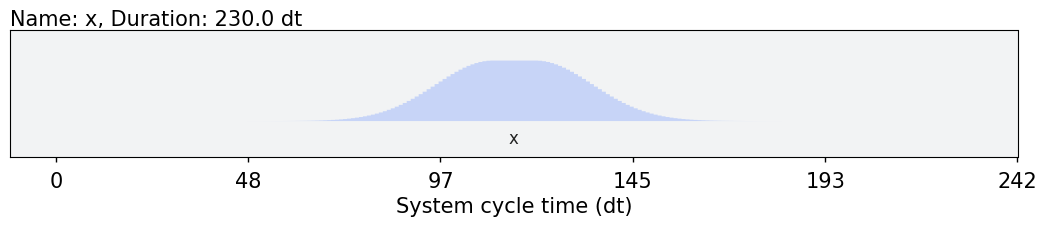

In [9]:
solution.gate.pulse().draw()
